In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# Data Import and Cleaning

In [2]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [3]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [4]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [5]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Peparing data for deep learning

In [9]:
data = TS1_A1A2[['wPreis']]
data

,wPreis
date,
2020-09-14,-37.519318
2020-09-28,-28.690096
2020-10-12,-29.688079
2020-10-19,-25.630433
2020-10-26,-29.073794
...,...
2023-08-07,7.832750
2023-08-14,3.525113
2023-08-21,3.896402


In [13]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    #df.set_index('date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'wPreis(t-{i})'] = df['wPreis'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 4
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,wPreis,wPreis(t-1),wPreis(t-2),wPreis(t-3),wPreis(t-4)
date,,,,,
2020-10-26,-29.073794,-25.630433,-29.688079,-28.690096,-37.519318
2020-11-02,-24.936426,-29.073794,-25.630433,-29.688079,-28.690096
2020-11-09,-35.262095,-24.936426,-29.073794,-25.630433,-29.688079
2020-11-16,-28.065632,-35.262095,-24.936426,-29.073794,-25.630433
2020-11-23,-27.358749,-28.065632,-35.262095,-24.936426,-29.073794
...,...,...,...,...,...
2023-08-07,7.832750,7.458214,4.063304,16.847234,28.985554
2023-08-14,3.525113,7.832750,7.458214,4.063304,16.847234
2023-08-21,3.896402,3.525113,7.832750,7.458214,4.063304


In [14]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[-29.07379398, -25.6304334 , -29.68807862, -28.69009585,
        -37.51931788],
       [-24.93642602, -29.07379398, -25.6304334 , -29.68807862,
        -28.69009585],
       [-35.26209517, -24.93642602, -29.07379398, -25.6304334 ,
        -29.68807862],
       [-28.06563229, -35.26209517, -24.93642602, -29.07379398,
        -25.6304334 ],
       [-27.35874871, -28.06563229, -35.26209517, -24.93642602,
        -29.07379398],
       [-28.21685813, -27.35874871, -28.06563229, -35.26209517,
        -24.93642602],
       [-29.18520815, -28.21685813, -27.35874871, -28.06563229,
        -35.26209517],
       [-32.36064526, -29.18520815, -28.21685813, -27.35874871,
        -28.06563229],
       [-20.27214677, -32.36064526, -29.18520815, -28.21685813,
        -27.35874871],
       [-18.80845203, -20.27214677, -32.36064526, -29.18520815,
        -28.21685813],
       [-35.43666563, -18.80845203, -20.27214677, -32.36064526,
        -29.18520815],
       [-23.58340467, -35.43666563, -18.808

In [15]:
shifted_df_as_np.shape

(150, 5)

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-8.72420819e-01, -8.03379489e-01, -8.84737574e-01,
        -8.64727454e-01, -1.00000000e+00],
       [-7.89464247e-01, -8.72420819e-01, -8.03379489e-01,
        -8.84737574e-01, -8.26589760e-01],
       [-9.96499763e-01, -7.89464247e-01, -8.72420819e-01,
        -8.03379489e-01, -8.46190630e-01],
       [-8.52206606e-01, -9.96499763e-01, -7.89464247e-01,
        -8.72420819e-01, -7.66496493e-01],
       [-8.38033190e-01, -8.52206606e-01, -9.96499763e-01,
        -7.89464247e-01, -8.34125779e-01],
       [-8.55238770e-01, -8.38033190e-01, -8.52206606e-01,
        -9.96499763e-01, -7.52865848e-01],
       [-8.74654736e-01, -8.55238770e-01, -8.38033190e-01,
        -8.52206606e-01, -9.55667042e-01],
       [-9.38324049e-01, -8.74654736e-01, -8.55238770e-01,
        -8.38033190e-01, -8.14324990e-01],
       [-6.95942806e-01, -9.38324049e-01, -8.74654736e-01,
        -8.55238770e-01, -8.00441451e-01],
       [-6.66594897e-01, -6.95942806e-01, -9.38324049e-01,
        -8.74654736e-01

In [17]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((150, 4), (150,))

In [18]:
X

array([[-8.03379489e-01, -8.84737574e-01, -8.64727454e-01,
        -1.00000000e+00],
       [-8.72420819e-01, -8.03379489e-01, -8.84737574e-01,
        -8.26589760e-01],
       [-7.89464247e-01, -8.72420819e-01, -8.03379489e-01,
        -8.46190630e-01],
       [-9.96499763e-01, -7.89464247e-01, -8.72420819e-01,
        -7.66496493e-01],
       [-8.52206606e-01, -9.96499763e-01, -7.89464247e-01,
        -8.34125779e-01],
       [-8.38033190e-01, -8.52206606e-01, -9.96499763e-01,
        -7.52865848e-01],
       [-8.55238770e-01, -8.38033190e-01, -8.52206606e-01,
        -9.55667042e-01],
       [-8.74654736e-01, -8.55238770e-01, -8.38033190e-01,
        -8.14324990e-01],
       [-9.38324049e-01, -8.74654736e-01, -8.55238770e-01,
        -8.00441451e-01],
       [-6.95942806e-01, -9.38324049e-01, -8.74654736e-01,
        -8.17295140e-01],
       [-6.66594897e-01, -6.95942806e-01, -9.38324049e-01,
        -8.36314008e-01],
       [-1.00000000e+00, -6.66594897e-01, -6.95942806e-01,
      

In [19]:
y

array([-8.72420819e-01, -7.89464247e-01, -9.96499763e-01, -8.52206606e-01,
       -8.38033190e-01, -8.55238770e-01, -8.74654736e-01, -9.38324049e-01,
       -6.95942806e-01, -6.66594897e-01, -1.00000000e+00, -7.62335403e-01,
       -7.51966329e-01, -7.50594546e-01, -9.19456021e-01, -7.99967686e-01,
       -7.64311152e-01, -7.20115084e-01, -8.31422500e-01, -7.87185268e-01,
       -7.55754905e-01, -7.97194808e-01, -7.36685225e-01, -7.58261901e-01,
       -7.94150546e-01, -7.07693820e-01, -7.62738121e-01, -7.87940739e-01,
       -7.63578616e-01, -8.05341016e-01, -6.94050776e-01, -8.18178365e-01,
       -7.28689268e-01, -7.63515664e-01, -7.91643841e-01, -7.83839579e-01,
       -7.26039701e-01, -7.89659080e-01, -7.68851339e-01, -7.95501825e-01,
       -6.85137571e-01, -7.81534574e-01, -7.85489318e-01, -7.50040549e-01,
       -6.74677211e-01, -6.23665895e-01, -8.21774505e-01, -7.39629910e-01,
       -7.49296530e-01, -7.58299605e-01, -7.56257615e-01, -8.23986049e-01,
       -7.32131807e-01, -

In [20]:
X = dc(np.flip(X, axis=1))
X

array([[-1.00000000e+00, -8.64727454e-01, -8.84737574e-01,
        -8.03379489e-01],
       [-8.26589760e-01, -8.84737574e-01, -8.03379489e-01,
        -8.72420819e-01],
       [-8.46190630e-01, -8.03379489e-01, -8.72420819e-01,
        -7.89464247e-01],
       [-7.66496493e-01, -8.72420819e-01, -7.89464247e-01,
        -9.96499763e-01],
       [-8.34125779e-01, -7.89464247e-01, -9.96499763e-01,
        -8.52206606e-01],
       [-7.52865848e-01, -9.96499763e-01, -8.52206606e-01,
        -8.38033190e-01],
       [-9.55667042e-01, -8.52206606e-01, -8.38033190e-01,
        -8.55238770e-01],
       [-8.14324990e-01, -8.38033190e-01, -8.55238770e-01,
        -8.74654736e-01],
       [-8.00441451e-01, -8.55238770e-01, -8.74654736e-01,
        -9.38324049e-01],
       [-8.17295140e-01, -8.74654736e-01, -9.38324049e-01,
        -6.95942806e-01],
       [-8.36314008e-01, -9.38324049e-01, -6.95942806e-01,
        -6.66594897e-01],
       [-8.98681146e-01, -6.95942806e-01, -6.66594897e-01,
      

In [21]:
len(X)

150

In [22]:
split_index = int(len(X) * 0.96)

split_index

144

In [23]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((144, 4), (6, 4), (144,), (6,))

In [24]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((144, 4, 1), (6, 4, 1), (144, 1), (6, 1))

In [26]:
# X_train
y_train

array([[-8.72420819e-01],
       [-7.89464247e-01],
       [-9.96499763e-01],
       [-8.52206606e-01],
       [-8.38033190e-01],
       [-8.55238770e-01],
       [-8.74654736e-01],
       [-9.38324049e-01],
       [-6.95942806e-01],
       [-6.66594897e-01],
       [-1.00000000e+00],
       [-7.62335403e-01],
       [-7.51966329e-01],
       [-7.50594546e-01],
       [-9.19456021e-01],
       [-7.99967686e-01],
       [-7.64311152e-01],
       [-7.20115084e-01],
       [-8.31422500e-01],
       [-7.87185268e-01],
       [-7.55754905e-01],
       [-7.97194808e-01],
       [-7.36685225e-01],
       [-7.58261901e-01],
       [-7.94150546e-01],
       [-7.07693820e-01],
       [-7.62738121e-01],
       [-7.87940739e-01],
       [-7.63578616e-01],
       [-8.05341016e-01],
       [-6.94050776e-01],
       [-8.18178365e-01],
       [-7.28689268e-01],
       [-7.63515664e-01],
       [-7.91643841e-01],
       [-7.83839579e-01],
       [-7.26039701e-01],
       [-7.89659080e-01],
       [-7.6

In [27]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([144, 4, 1]),
 torch.Size([6, 4, 1]),
 torch.Size([144, 1]),
 torch.Size([6, 1]))

In [28]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [29]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 4, 1]) torch.Size([32, 1])


In [31]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [32]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [33]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [34]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.338
***************************************************

Epoch: 2

Val Loss: 0.319
***************************************************

Epoch: 3

Val Loss: 0.301
***************************************************

Epoch: 4

Val Loss: 0.283
***************************************************

Epoch: 5

Val Loss: 0.266
***************************************************

Epoch: 6

Val Loss: 0.249
***************************************************

Epoch: 7

Val Loss: 0.233
***************************************************

Epoch: 8

Val Loss: 0.217
***************************************************

Epoch: 9

Val Loss: 0.202
***************************************************

Epoch: 10

Val Loss: 0.188
***************************************************



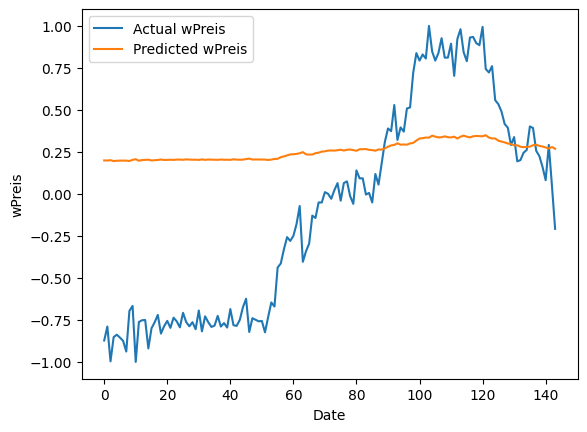

In [35]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual wPreis')
plt.plot(predicted, label='Predicted wPreis')
plt.xlabel('Date')
plt.ylabel('wPreis')
plt.legend()
plt.show()


In [36]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([24.3824138 , 24.34426047, 24.4556266 , 24.17485875, 24.27372163,
       24.33500269, 24.34228807, 24.32262133, 24.20684889, 24.54194833,
       24.74615536, 24.29390786, 24.48169955, 24.5542799 , 24.60706196,
       24.36534074, 24.44071248, 24.52504844, 24.64756522, 24.5199859 ,
       24.53458714, 24.58508021, 24.53919708, 24.62915296, 24.62539173,
       24.56531834, 24.68762034, 24.63959463, 24.58346974, 24.59812152,
       24.5288067 , 24.69407485, 24.55060191, 24.64765812, 24.62279432,
       24.5658237 , 24.55802106, 24.64729545, 24.57972858, 24.59102936,
       24.54571773, 24.71485488, 24.6218215 , 24.58198562, 24.61916315,
       24.76228011, 24.92477027, 24.6441897 , 24.67002335, 24.64740841,
       24.62832209, 24.63289338, 24.51547109, 24.62101218, 24.81582542,
       24.86264719, 25.33525036, 25.57903093, 25.87625648, 26.16229346,
       26.21623786, 26.31429365, 26.50926073, 26.84216928, 26.18925749,
       26.10479296, 26.13452755, 26.52977247, 26.68015178, 26.98

In [37]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([-29.07379541, -24.93642542, -35.26209584, -28.06563139,
       -27.3587492 , -28.21685941, -29.18520687, -32.36064452,
       -20.27214742, -18.80845328, -35.43666563, -23.58340551,
       -23.0662599 , -22.99784284, -31.41962228, -25.4602745 ,
       -23.68194213, -21.47771168, -27.02904821, -24.82276361,
       -23.25520872, -25.3219778 , -22.30412977, -23.38024414,
       -25.17014929, -20.85821545, -23.60348918, -24.86044279,
       -23.64540745, -25.7282619 , -20.17778449, -26.36851066,
       -21.90533989, -23.64226826, -25.04513171, -24.65590208,
       -21.77319671, -24.94614323, -23.90837988, -25.23754374,
       -19.73324747, -24.54094119, -24.73818092, -22.97021144,
       -19.21154766, -16.66741386, -26.54786355, -22.45099385,
       -22.93310599, -23.38212289, -23.28028061, -26.65816321,
       -22.07703209, -17.78618968, -18.98931037,  -7.41127323,
        -6.21131848,  -1.98035252,   1.61215128,   0.480841  ,
         1.99070217,   5.50021813,  10.84846909,  -5.71

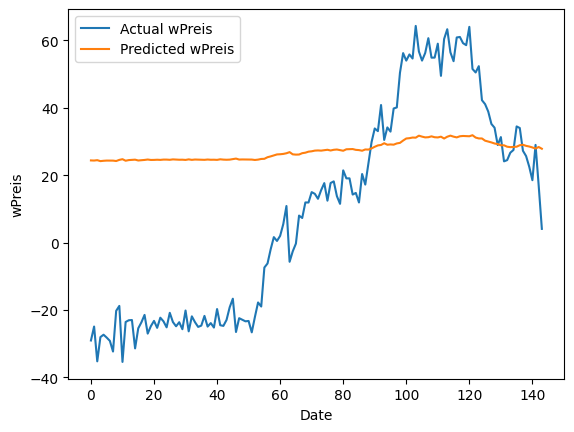

In [38]:
plt.plot(new_y_train, label='Actual wPreis')
plt.plot(train_predictions, label='Predicted wPreis')
plt.xlabel('Date')
plt.ylabel('wPreis')
plt.legend()
plt.show()


In [39]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([27.03808614, 26.90122005, 26.81413062, 26.59423285, 26.55123102,
       26.65645329])

In [40]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([7.45821404, 7.83275027, 3.5251135 , 3.89640205, 6.75448292,
       2.05326447])

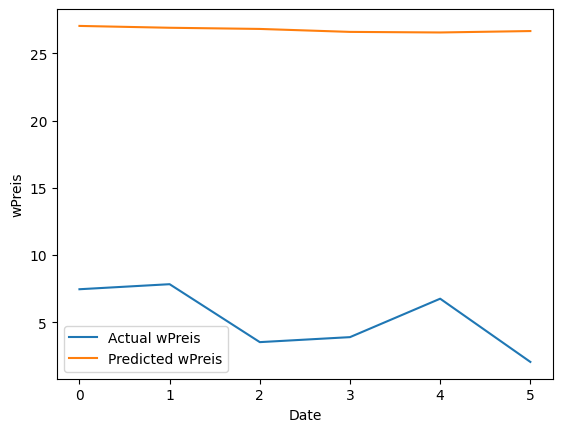

In [41]:
plt.plot(new_y_test, label='Actual wPreis')
plt.plot(test_predictions, label='Predicted wPreis')
plt.xlabel('Date')
plt.ylabel('wPreis')
plt.legend()
plt.show()


In [10]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=4):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [11]:
supervised = timeseries_to_supervised(X, 4)
print(supervised.head())

           0          0          0          0          0
0   0.000000   0.000000   0.000000   0.000000 -37.519318
1 -37.519318   0.000000   0.000000   0.000000 -28.690096
2 -28.690096 -37.519318   0.000000   0.000000 -29.688079
3 -29.688079 -28.690096 -37.519318   0.000000 -25.630433
4 -25.630433 -29.688079 -28.690096 -37.519318 -29.073794


In [12]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [13]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [14]:
# transform to be stationary
series = X
differenced = difference(series, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
 value = inverse_difference(series, differenced[i], len(series)-i)
 inverted.append(value)
inverted = pd.Series(inverted)
print(inverted.head())

0    8.829222
1   -0.997983
2    4.057645
3   -3.443361
4    4.137368
dtype: float64
0   -28.690096
1   -29.688079
2   -25.630433
3   -29.073794
4   -24.936426
dtype: float64


In [15]:
differenced.shape

(153,)

In [16]:
inverted.shape

(153,)

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
X_2 = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X_2)
scaled_X = scaler.transform(X_2)

In [19]:
scaled_series = pd.Series(scaled_X[:, 0])
print(scaled_series.head())
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])
print(inverted_series.head())

0   -1.000000
1   -0.826590
2   -0.846191
3   -0.766496
4   -0.834126
dtype: float64
0   -37.519318
1   -28.690096
2   -29.688079
3   -25.630433
4   -29.073794
dtype: float64


In [20]:
def scale(train, test):
 # fit scaler
 scaler = MinMaxScaler(feature_range=(-1, 1))
 scaler = scaler.fit(train)
 # transform train
 train = train.reshape(train.shape[0], train.shape[1])
 train_scaled = scaler.transform(train)
 # transform test
 test = test.reshape(test.shape[0], test.shape[1])
 test_scaled = scaler.transform(test)
 return scaler, train_scaled, test_scaled

In [21]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
 new_row = [x for x in X] + [value]
 array = np.array(new_row)
 array = array.reshape(1, len(array))
 inverted = scaler.inverse_transform(array)
 return inverted[0, -1]

## LSTM

In [1]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

In [18]:
import tensorflow.keras as keras

ModuleNotFoundError: No module named 'tensorflow.keras'

In [12]:
import keras

ModuleNotFoundError: No module named 'tensorflow.compat'

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

ModuleNotFoundError: No module named 'tensorflow.keras'